<a href="https://colab.research.google.com/github/TAMIDSpiyalong/ECEN-689/blob/main/Lab_5_cotton_water_stress_classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with the Cotton Image


In this section we will do the "Hello World" of deep learning: training a convolutional neural network (CNN) model to correctly classify the cotton water stress.

## Objectives

* Understand how deep learning can solve problems traditional programming methods cannot
* Learn about the [cotton image dataset](http://yann.lecun.com/exdb/mnist/)
* Use the [Keras API](https://keras.io/) to load the MNIST dataset and prepare it for training
* Create a simple convolutional neural network to perform image classification
* Train the convolutional neural network using the prepped cotton image dataset
* Observe the performance of the trained CNN model

## The Problem: Image Classification

In traditional programming, the programmer is able to articulate rules and conditions in their code that their program can then use to act in the correct way. This approach continues to work exceptionally well for a huge variety of problems.

Image classification, which asks a program to correctly classify an image it has never seen before into its correct class, is near impossible to solve with traditional programming techniques. How could a programmer possibly define the rules and conditions to correctly classify a huge variety of images, especially taking into account images that they have never seen?

## The Solution: Deep Learning

Deep learning excels at pattern recognition by trial and error. By training a deep neural network, such as CNN, with sufficient data, and providing the network with feedback on its performance via training, the network can identify, though a huge amount of iteration, its own set of conditions by which it can act in the correct way.

In this section, we loaded the dataset to show what the dataset looks like.

In [39]:
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=1vYSdI8ESMxoZfReDWA7UyGu8G6MVDgHW')

gdown.download('https://drive.google.com/uc?export=download&id=1eVjd8tCCpQHouOHaeAAk-YOtflDSQ3vD')


Downloading...
From: https://drive.google.com/uc?export=download&id=1vYSdI8ESMxoZfReDWA7UyGu8G6MVDgHW
To: /content/twri_rgb_6832_cotton_64x64_9_02.npy
100%|██████████| 672M/672M [00:07<00:00, 91.2MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1eVjd8tCCpQHouOHaeAAk-YOtflDSQ3vD
To: /content/labels_rgb (2).csv
100%|██████████| 74.5k/74.5k [00:00<00:00, 27.3MB/s]


'labels_rgb (2).csv'

In [40]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import sys
import numpy
# The skimage library has several different methods of thresholding
import numpy as np
import glob
import matplotlib.pyplot as plt
import skimage.color
import skimage.filters
from skimage.morphology import opening, closing, erosion, dilation
from skimage.morphology import disk  # noqa
from skimage.color import rgb2lab
class_names = ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
numpy.set_printoptions(threshold=sys.maxsize)

In [41]:
# During the class, please ask the students to change the following data path to where they saved the dataset
data = np.load('twri_rgb_6832_cotton_64x64_9_02.npy')
labels = pd.read_csv('labels_rgb (2).csv')
y_label = labels['class'].values

new_data_without_filler = np.zeros((5376, 64, 64, 3))
new_y_label_without_filler = np.zeros(5376, dtype=int)
i = 0
for idx, val in enumerate(y_label):
  if val != 0:
    new_data_without_filler[i] = data[idx]
    new_y_label_without_filler[i] = y_label[idx]
    i+=1
data = new_data_without_filler
y_label = new_y_label_without_filler - 1

In [42]:
data.shape

(5376, 64, 64, 3)

In [43]:
from collections import Counter
Counter(y_label)

Counter({0: 1344, 2: 1344, 3: 1344, 1: 1344})

## The Cotton Image Dataset

The study aimed to classify cotton water stress using advanced CNN models. The cotton image was collected by a UAV system at Lubbock, Texas. A DJI Phantom 4 was utilized as the UAV platform for collecting high-resolution RGB images at an altitude of 90 meters. The UAV image was preprocessed with ArcGIS Pro, which created 6832 images for each sampling date.

*Here* are 25 of the images included in the cotton image dataset:

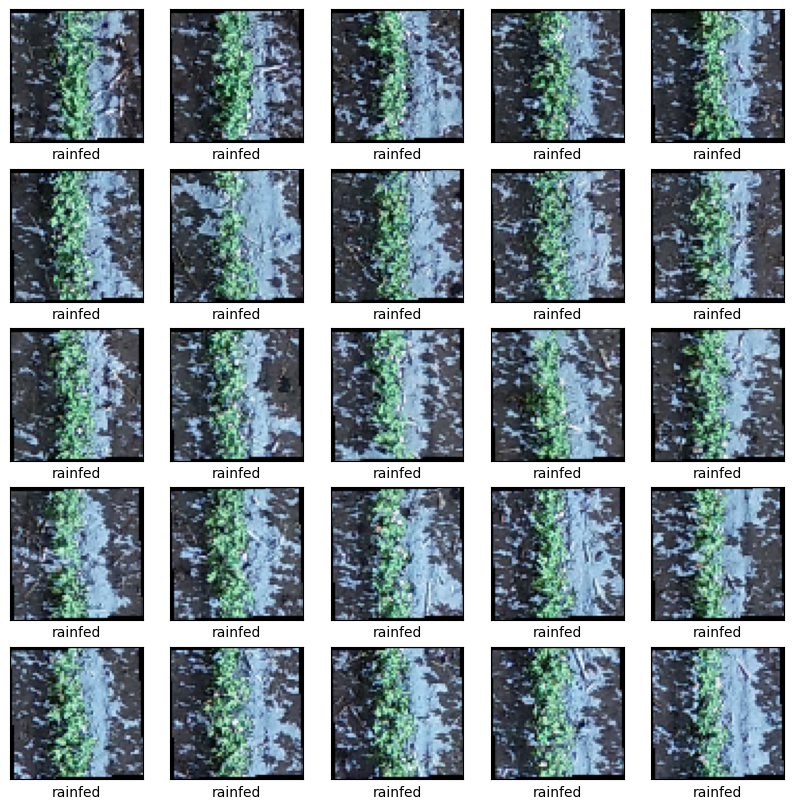

In [44]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i]/255)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_label[i]])
plt.show() # because we did not shuffle the dataset yet, that's why the first 25 images all come from class 0, which is "rainfed"

## Training and Validation Data and Labels

When working with images for deep learning, we need both the images themselves, usually denoted as `X`, and also, correct [labels](https://developers.google.com/machine-learning/glossary#label) for these images, usually denoted as `Y`. Furthermore, we need `X` and `Y` values both for *training* the model, and then, a separate set of `X` and `Y` values for *validating* the performance of the model after it has been trained. Therefore, we need 4 segments of data for the cotton image dataset:

1. `x_train`: Images used for training the CNN model
2. `y_train`: Correct labels for the `x_train` images, used to evaluate the model's predictions during training
3. `x_valid`: Images set aside for validating the performance of the model after it has been trained
4. `y_valid`: Correct labels for the `x_valid` images, used to evaluate the model's predictions after it has been trained

The process of preparing data for analysis is called [Data Engineering](https://medium.com/@rchang/a-beginners-guide-to-data-engineering-part-i-4227c5c457d7). To learn more about the differences between training data and validation data (as well as test data), check out [this article](https://machinelearningmastery.com/difference-test-validation-datasets/) by Jason Brownlee.

## Loading the Data Into Memory

There are many [deep learning frameworks](https://developer.nvidia.com/deep-learning-frameworks), each with their own merits. In this workshop we will be working with [Tensorflow 2](https://www.tensorflow.org/tutorials/quickstart/beginner), and specifically with the [Keras API](https://keras.io/). Keras has many useful built in functions designed for the computer vision tasks. It is also a legitimate choice for deep learning in a professional setting due to its [readability](https://blog.pragmaticengineer.com/readable-code/) and efficiency, though it is not alone in this regard, and it is worth investigating a variety of frameworks when beginning a deep learning project.

One of the many helpful features that Keras provides are modules containing many helper methods for [many common datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

We will begin by partitioning the cotton image dataset into training and testing with train_test_split method.

In [45]:
# the data, split between train and validation sets
train_images, test_images, train_labels, test_labels = train_test_split(data, y_label, test_size=0.3, random_state=42)
train_images, test_images = train_images / 255.0, test_images / 255.0

## Exploring the Cotton Image Dataset

We stated above that the cotton image dataset contained 5376 RGB images of cotton canopy. By executing the following cells, we can see that Keras has partitioned 3763 of these images for training, and 1613 for validation (after training), and also, that each image itself is a 3D array with the dimensions 64x64x3:

In [46]:
train_images.shape

(3763, 64, 64, 3)

In [47]:
test_images.shape

(1613, 64, 64, 3)

Furthermore, we can see that these 64x64x3 images are represented as a collection of float64 values between 0.0 and 1.0.

In [48]:
train_images.dtype

dtype('float64')

In [49]:
train_images.min()

0.0

In [50]:
train_images.max()

1.0

Using [Matplotlib](https://matplotlib.org/), we can render one of these grayscale images in our dataset:

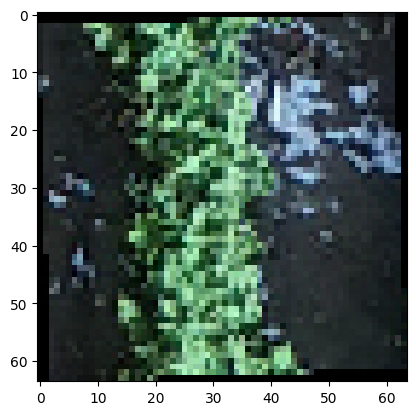

In [51]:
image = train_images[0]
plt.imshow(image)

In this way we can now see that this is a 64x64x3 pixel image of a cotton canopy. What is the corresponding label? The answer is in the `train_labels` data, which contains correct labels for the data. Remember that class_names = ['rainfed'(0), 'fully irrigated' (1), 'percent deficit' (2), 'time delay' (3)]. Let's take a look:

In [52]:
train_labels[0]

1

Now, let's display the first 25 images in the train_images. What can we expect?

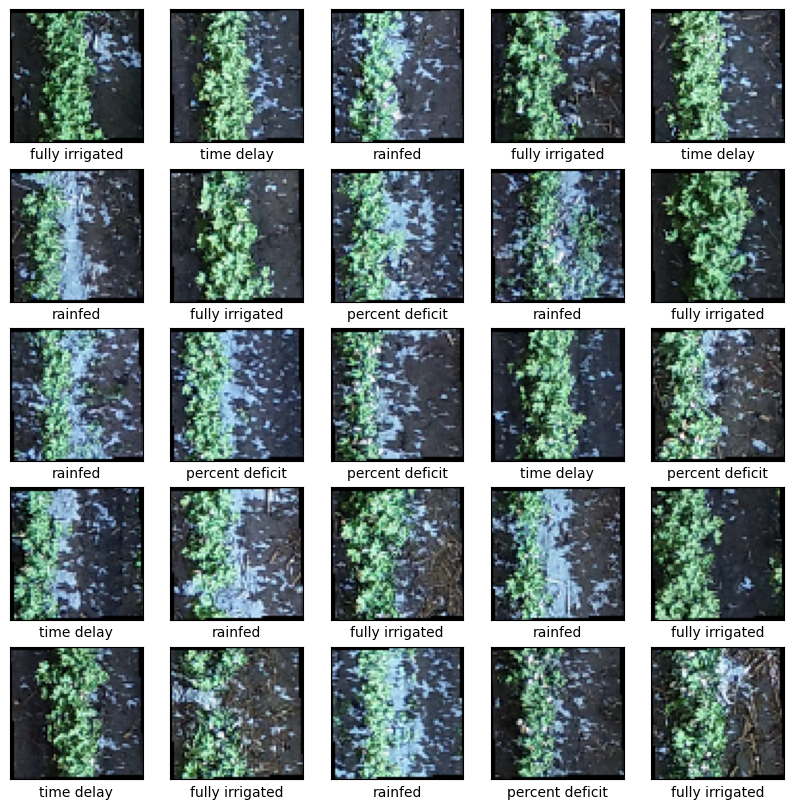

In [53]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i]) # pay attention that this time we did not divide the train_images by 255, why?
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Wow! Our train_images were randomly shuffled by train_test_split method. We just displayed images from all the four classes.  

## Creating the Model

With the data prepared for training, it is now time to create the model that we will train with the data. This first basic model will be made up of several *layers* and will be comprised of 3 main parts:

1. An input layer, which will receive data in some expected format
2. Several [hidden layers](https://developers.google.com/machine-learning/glossary#hidden-layer), each comprised of many *neurons*. Each [neuron](https://developers.google.com/machine-learning/glossary#neuron) will have the ability to affect the network's guess with its *weights*, which are values that will be updated over many iterations as the network gets feedback on its performance and learns
3. An output layer, which will depict the network's guess for a given image

### Instantiating the Model

To begin, we will use Keras's [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model class to instantiate an instance of a model that will have a series of layers that data will pass through in sequence:

In [54]:
model = models.Sequential()

### Creating the Input Layer

Next, we will add the input Conv2D layers and MaxPooling2D layers.

We will use the `relu` activation function, which in short, will help our network to learn how to make more sophisticated guesses about data than if it were required to make guesses based on some strictly linear function.

The `input_shape` value specifies the shape of the incoming data which in our situation is a 3D array of 64x64x3:

In [55]:
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Now we will add an additional densely connected layer. Again, much more will be said about these later, but for now know that these layers give the network more parameters to contribute towards its guesses, and therefore, more subtle opportunities for accurate learning:

In [56]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))

### Creating the Output Layer

Finally, we will add an output layer. This layer result in each of the layer's values being a probability between 0 and 1 and will result in all the outputs of the layer adding to 1. In this case, since the network is to make a guess about a single image belonging to 1 of 4 possible irrigation levels, there will be 4 outputs. Each output gives the model's guess (a probability) that the image belongs to that specific class:

In [57]:
model.add(layers.Dense(4))

### Summarizing the Model

Keras provides the model instance method [summary](https://www.tensorflow.org/api_docs/python/tf/summary) which will print a readable summary of a model:

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 9216)             

Note the number of trainable parameters. Each of these can be adjusted during training and will contribute towards the trained model's guesses.

### Compiling the Model

Again, more details are to follow, but the final step we need to do before we can actually train our model with data is to [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile) it. Here we specify a [loss function](https://developers.google.com/machine-learning/glossary#loss) which will be used for the model to understand how well it is performing during training. We also specify that we would like to track `accuracy` while the model trains:

In [59]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

## Training the Model

Now that we have prepared training and validation data, and a model, it's time to train our model with our training data, and verify it with its validation data.

"Training a model with data" is often also called "fitting a model to data." Put this latter way, it highlights that the shape of the model changes over time to more accurately understand the data that it is being given.

When fitting (training) a model with Keras, we use the model's [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. It expects the following arguments:

* The training data
* The labels for the training data
* The number of times it should train on the entire training dataset (called an *epoch*)
* The validation or test data, and its labels

Run the cell below to train the model. We will discuss its output after the training completes:

In [60]:
history = model.fit(train_images, train_labels, epochs=70,
                      validation_data=(test_images, test_labels))

Epoch 1/70
118/118 [==============================] - 3s 12ms/step - loss: 1.0422 - accuracy: 0.5116 - val_loss: 0.7843 - val_accuracy: 0.6671
Epoch 2/70
118/118 [==============================] - 1s 9ms/step - loss: 0.7799 - accuracy: 0.6628 - val_loss: 0.6922 - val_accuracy: 0.6832
Epoch 3/70
118/118 [==============================] - 1s 8ms/step - loss: 0.6877 - accuracy: 0.6947 - val_loss: 0.6363 - val_accuracy: 0.7235
Epoch 4/70
118/118 [==============================] - 1s 8ms/step - loss: 0.6051 - accuracy: 0.7436 - val_loss: 0.5481 - val_accuracy: 0.7694
Epoch 5/70
118/118 [==============================] - 1s 8ms/step - loss: 0.5067 - accuracy: 0.7866 - val_loss: 0.5174 - val_accuracy: 0.7948
Epoch 6/70
118/118 [==============================] - 1s 8ms/step - loss: 0.4642 - accuracy: 0.8105 - val_loss: 0.5020 - val_accuracy: 0.8035
Epoch 7/70
118/118 [==============================] - 1s 7ms/step - loss: 0.4242 - accuracy: 0.8257 - val_loss: 0.4803 - val_accuracy: 0.8128
Epoch

### Observing Accuracy

For each of the epoch, notice the `accuracy` and `val_accuracy` scores. `accuracy` states how well the model did for the epoch on all the training data. `val_accuracy` states how well the model did on the validation data, which if you recall, was not used at all for training the model.

51/51 - 0s - loss: 1.2115 - accuracy: 0.8493 - 163ms/epoch - 3ms/step


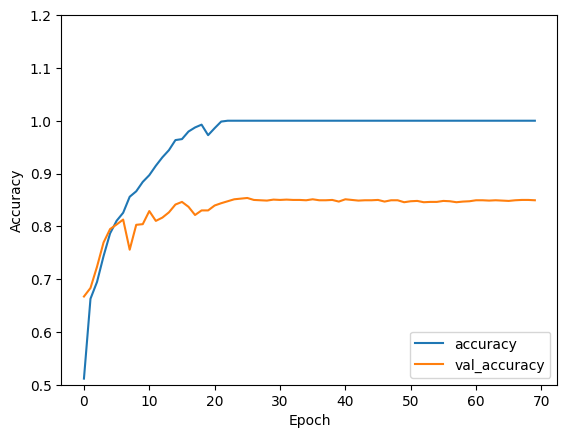

In [61]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.2])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

The model did quite well! The accuracy quickly reached close to 100%. The validation accuracy was around 87%. Consider it was a first trial without many paramerter tunings, the model performed very well. We now have a model that can be used to accurately detect and classify cotton water stress.

The next step would be to use this model to classify new not-yet-seen cotton canopy images. This is called [inference](https://blogs.nvidia.com/blog/2016/08/22/difference-deep-learning-training-inference-ai/). We'll explore the process of inference in the future.

## The performance evaluation of CNN model

In order to evaluate the performance of the trained CNN models, we can employe a confusion matrix, which provides a comprehensive summary of the prediction results in a classification problem. The confusion matrix helps in understanding not only the overall accuracy of the classifier but also the specific types of errors being made.

51/51 [==============================] - 0s 2ms/step


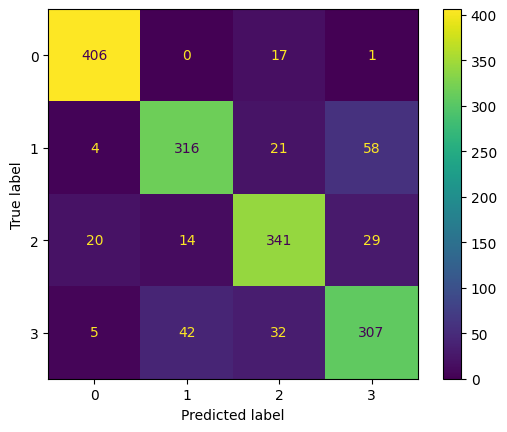

In [62]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
pred = np.argmax(predictions, axis=1)
tf.math.confusion_matrix(test_labels, pred)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_labels, pred)